# BTG Energy Challenge

### Introdução
Trabalhando nos sistema da mesa de Energia do banco BTG Pactual, constantemente lidamos com dados de precipitação, tanto previsto como observado. 
A informação de quanto choveu ou quanto choverá em determinado lugar é dada por uma malha de coordenadas 
(latitude [lat] e longitude [long]) e uma terceira variável que é a precipitação diária acumulada naquele ponto.

Na pasta `forecast_files` é possivel encontrar a previsão de precipitação do modelo meteorológico ETA, desenvolvido pelo INPE.
O nome dos arquivos seguem o seguinte padrão: ETA40_p011221a021221.dat -> ETA40_p**ddmmyy**a**ddmmyy**.dat. 
Em que a primeira data é referente a quando foi feita a previsão e a segunda data diz respeito qual data está sendo prevista.

Dentro do arquivo, os dados seguem o descrito acima:
```
lat     long    data_value
-75.00  -35.00  0.0
-75.00  -34.60  0.1
-75.00  -34.20  0.0
```

Porém, estes dados não são utilizados desta forma, eles passam por um processamento. Pois, uma das perguntas que queremos
responder no nosso dia a dia é: **Quanto choveu ou choverá em determinada região do Brasil?**. 

Para isso, utilizamos um **contorno**, que é um polígono consistido das coordenadas que delimitam uma região. 
Assim, conseguimos "recortar" os dados que caem dentro desta região e calcular, por exemplo, a precipitação média da região.

Por exemplo (valores inventados):
```
forecast_date   forecasted_date     data_value
01/12/2021      02/12/2021          1.4
01/12/2021      03/12/2021          2.1
...             ...                 ...
01/12/2021      07/12/2021          3.2
```


### O desafio
O desafio consiste em responder a seguinte pergunta: **Qual é a previsão de precipitação ACUMULADA dada pelo modelo ETA no dia 01/12/2021 para a região de escoamento da usina Hidrelétrica Camargos (bacia do rio Grande)?**

## Código Base

Modifique o arquivo `main.py` para fazer o "recorte" dos dados de precipitação (para **todos** os dias previstos pelo modelo) e 
apresente graficamente a resposta para a pergunta.


### Resalvas
- É permitido a utilização de bibliotecas extras
- A entrega do desafio deve ser feita por GIT. Responda o email com o link do seu repositório.

In [1]:
import re
import time
import pandas as pd

In [2]:
def read_data_file(file_path: str) -> pd.DataFrame:
    with open(file_path, 'r') as f:
        raw_file = f.readlines()

    list_dados = [line.split() for line in raw_file]
    float_raw_lines = [list(map(float, raw_line)) for raw_line in list_dados]
    return pd.DataFrame(float_raw_lines, columns=['lat', 'long', 'data_value'])


def read_contour_file(file_path: str) -> pd.DataFrame:
    line_split_comp = re.compile(r'\s*,')

    with open(file_path, 'r') as f:
        raw_file = f.readlines()

    l_raw_lines = [line_split_comp.split(raw_file_line.strip()) for raw_file_line in raw_file]
    l_raw_lines = list(filter(lambda item: bool(item[0]), l_raw_lines))
    float_raw_lines = [list(map(float, raw_line))[:2] for raw_line in l_raw_lines]
    header_line = float_raw_lines.pop(0)
    assert len(float_raw_lines) == int(header_line[0])
    return pd.DataFrame(float_raw_lines, columns=['lat', 'long'])

## Implementação

Para responder a questão desse problema é possível fazer várias abordagens para chegar ao resultado solicidado.

O motivo disso é que às coordenadas do modelo não se referem exatamente ao valor acumulado de um ponto específico, mas sim de uma `região` ou `grade` que indica a forma como o modelo discretiza a atmosfera para realizar seus cálculos.
Modelos numéricos de previsão do tempo dividem a atmosfera em uma grade tridimensional de pontos horizontais e verticais.
A grade horizontal define o espaçamento e a resolução desses pontos nas direções de latitude e longitude.

Tendo isso em mente é possível descrever 3 possíveis cenários, sendo eles:

1. Consideramos apenas os pontos que pertencem a região da bacia do Rio Grande.
    1. Dessa forma não iremos levar em consideração os pontos fora da região mas que comportam uma parte dela, muito menos a área da região pertencente à grade do modelo.
    2. ![alt text](imgs/1.png "Title")
2. Consideramos os pontos que pertencem a região da bacia do Rio Grande e pontos dos quais alguma região da grade pertença a região da bacia.
    1. Contudo ainda não estamos levando em consideração a proporção dessas áreas.
    2. ![alt text](imgs/2.png "Title")
3. Consideramos às areas proporcionais da grade que estão contidas na região.
    1. ![alt text](imgs/3.png "Title") |


In [3]:
from shapely.geometry import Point, Polygon
#
# Implementação 1
#
def apply_contour_1(contour_df: pd.DataFrame, data_df: pd.DataFrame) -> pd.DataFrame:
    region_polygon: Polygon = Polygon(contour_df[['lat', 'long']].values)

    def point_within_region(point: Point, region_polygon: Polygon) -> bool:
        return region_polygon.contains(Point(point['lat'], point['long']))
    
    filtered_data_df = data_df[data_df.apply(point_within_region, region_polygon=region_polygon, axis=1)]

    return filtered_data_df

In [4]:
#
# Implementação 2
#
def apply_contour_2(contour_df: pd.DataFrame, data_df: pd.DataFrame) -> pd.DataFrame:
    steps = data_df.lat.diff().apply(lambda x: round(x, 2)).dropna().drop_duplicates(keep='first')
    data_df['step'] = steps[steps > 0].values[0]
    
    region_polygon: Polygon = Polygon(contour_df[['lat', 'long']].values)

    def square_within_region(point, region_polygon: Polygon):
        lat, long = point['lat'], point['long']

        half_side = point['step'] / 2
        square_polygon = Polygon([
            (lat + half_side, long - half_side),
            (lat + half_side, long + half_side),
            (lat - half_side, long + half_side),
            (lat - half_side, long - half_side),
        ])

        if square_polygon.intersects(region_polygon):
            return True
        return False
    
    filtered_data_df = data_df[data_df.apply(square_within_region, region_polygon=region_polygon, axis=1)]
    
    return filtered_data_df

In [5]:
#
# Implementação 3
#
def apply_contour_3(contour_df: pd.DataFrame, data_df: pd.DataFrame) -> pd.DataFrame:
    steps = data_df.lat.diff().apply(lambda x: round(x, 2)).dropna().drop_duplicates(keep='first')
    data_df['step'] = steps[steps > 0].values[0]
    
    region_polygon: Polygon = Polygon(contour_df[['lat', 'long']].values)

    def square_within_region(point, region_polygon: Polygon):
        lat, long = point['lat'], point['long']
        
        half_side = point['step'] / 2
        square_polygon = Polygon([
            (lat + half_side, long - half_side),
            (lat + half_side, long + half_side),
            (lat - half_side, long + half_side),
            (lat - half_side, long - half_side),
        ])

        if square_polygon.intersects(region_polygon):
            intersection = square_polygon.intersection(region_polygon)
            return (True, intersection.area)
        return (False, 0.0)
       
    mask_area = data_df.apply(square_within_region, region_polygon=(region_polygon), axis=1)
    mask_area = mask_area.apply(pd.Series)
    mask_area.columns = ['mask', 'area']

    filtered_data_df = data_df[mask_area['mask']]

    r = filtered_data_df.join(mask_area['area'])
    
    r.update({
        'data_value': r.apply(lambda x: x.area * x.data_value / x.step**2, axis=1)
    })
    
    return r

## Funções auxiliares

In [6]:
import os

def get_forcast_dates(forcast_file_name: str) -> list:
    matches = re.findall(r'(\d{2})(\d{2})(\d{2})', forcast_file_name)
    dates_ddmmyy = [f'{day}/{month}/{year}' for day, month, year in matches]
    return dates_ddmmyy

def read_data_files(forcast_folder):
    combined_data = pd.DataFrame()

    for forcast_file in os.listdir(forcast_folder):
        date0, date1 = get_forcast_dates(forcast_file)
       
        df = read_data_file(f'{forcast_folder}/{forcast_file}')
        df = df.assign(forecast_date=date0, forecasted_date=date1)
        
        combined_data = pd.concat([combined_data, df], ignore_index=True)

    return combined_data

## Plotting

In [7]:
import matplotlib.pyplot as plt

def map_plot(contour_df: pd.DataFrame, filtered_data_df: pd.DataFrame, ax) -> None:
    points_to_plot = filtered_data_df[['lat', 'long']].drop_duplicates()
    points_to_plot['side'] = 0.4
    sqr_fill = True
    
    ax.set_title('Camargos - Bacia do Grande')
    
    ax.plot(contour_df['lat'], contour_df['long'], c='#0a0a0a', label='Region')
    
    if 'area' in filtered_data_df.columns:
        ax.fill(contour_df['lat'], contour_df['long'], c='#42f5e0', label='Region')
        sqr_fill = False
        
    for index, row in points_to_plot.iterrows():
        center_x = row['lat']
        center_y = row['long']
        side_length = row['side']
        
        x_left = center_x - side_length / 2
        x_right = center_x + side_length / 2
        y_bottom = center_y - side_length / 2
        y_top = center_y + side_length / 2
    
        ax.add_patch(
            plt.Rectangle((x_left, y_bottom), side_length, side_length, fill=sqr_fill, facecolor="#00d9ff",  edgecolor='#ff0000')
        )
    
    ax.scatter(points_to_plot['lat'], points_to_plot['long'], c='g', label='Points within Region')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.axis('equal')
    ax.legend()

def forcast_plot(filtered_data_df: pd.DataFrame, ax):
    # Considerando que a medida utilizada para o valor da precipitaçõa do modelo esteja em unidades de comprimento de água
    # Temos que fazer a média (`mean`) das sub regiões, mas caso o valor fosse em volume de água seria uma soma (`sum`)
    forcast_df = filtered_data_df.groupby(by=['forecast_date','forecasted_date'])[['data_value']].mean()
    forcast_df['data_value_acc'] = forcast_df['data_value'].expanding(1).sum()
    
    forcast_df.plot(kind='barh', ax=ax)
    
    ax.set_title('Preciptation Forcast ISO x ACC')
    ax.legend(['Forcast Precipitation Iso','Forcast Precipitation Acc'])
    
    for container in ax.containers:
        ax.bar_label(container)

def result_plot(filtered_data_df: pd.DataFrame):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    map_plot(contour_df=contour_df, filtered_data_df=filtered_data_df, ax=ax1)
    
    forcast_plot(filtered_data_df=filtered_data_df, ax=ax2)
    
    plt.tight_layout()
    plt.show()

## Main

In [8]:
contour_df: pd.DataFrame = read_contour_file('PSATCMG_CAMARGOS.bln')
data_df: pd.DataFrame = read_data_files('forecast_files')

### Implementação 1

In [9]:
%%time
filtered_data_df: pd.DataFrame = apply_contour_1(contour_df=contour_df, data_df=data_df)

CPU times: total: 2.61 s
Wall time: 2.82 s


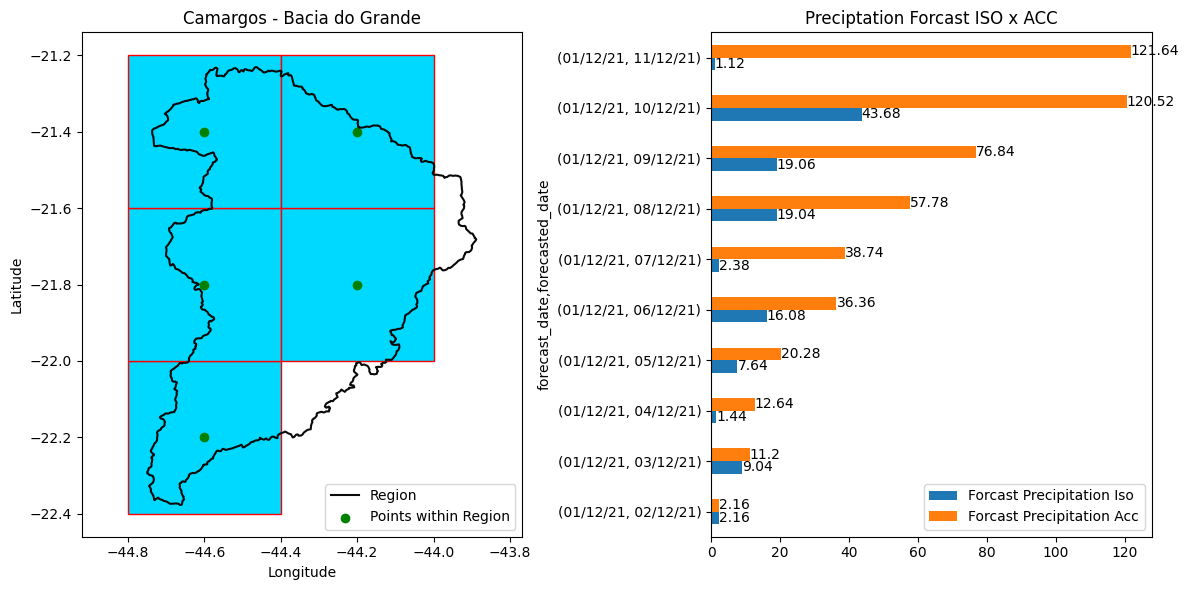

In [10]:
result_plot(filtered_data_df)

### Implementação 2

In [11]:
%%time
filtered_data_df: pd.DataFrame = apply_contour_2(contour_df=contour_df, data_df=data_df)

CPU times: total: 4.69 s
Wall time: 4.75 s


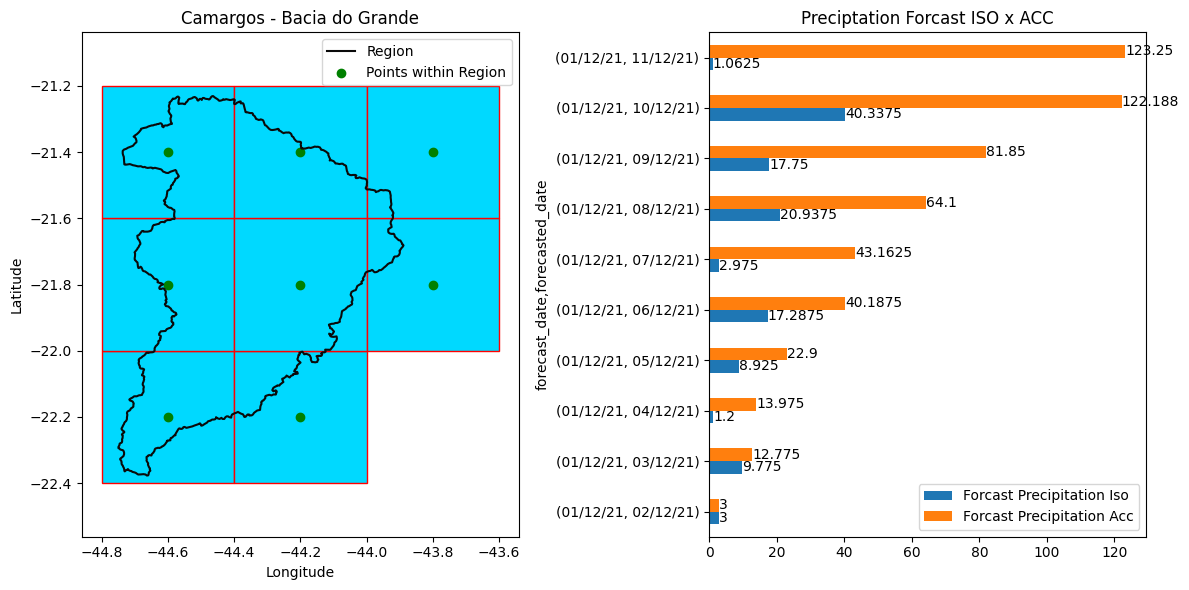

In [12]:
result_plot(filtered_data_df)

### Implementação 3

In [13]:
%%time
filtered_data_df: pd.DataFrame = apply_contour_3(contour_df=contour_df, data_df=data_df)

CPU times: total: 14.9 s
Wall time: 14.9 s


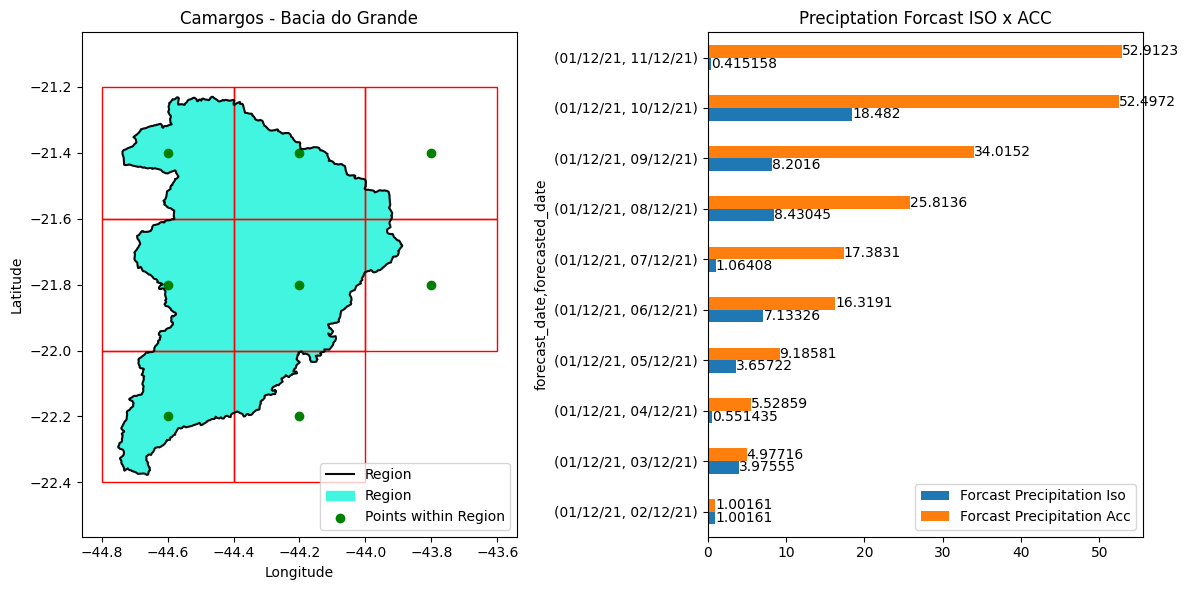

In [14]:
result_plot(filtered_data_df)

## Resultado

Para o resultado final a primeira implementação foi escolhida, pois era a que mais se assemelhava com o enunciado do problema

> e uma terceira variável que é a precipitação diária acumulada **naquele ponto** ... conseguimos **"recortar" os dados que caem dentro desta região**